# Overview of input - output mapping of the developed ABSA pipeline

* below you see a process flow of the developed ABSA demo app. The EPC and NER part are of particular interest for the validation based on Refinitiv data as these parts of the pipeline essentially consume the Refinitiv text and perform the to-be validated APC's.

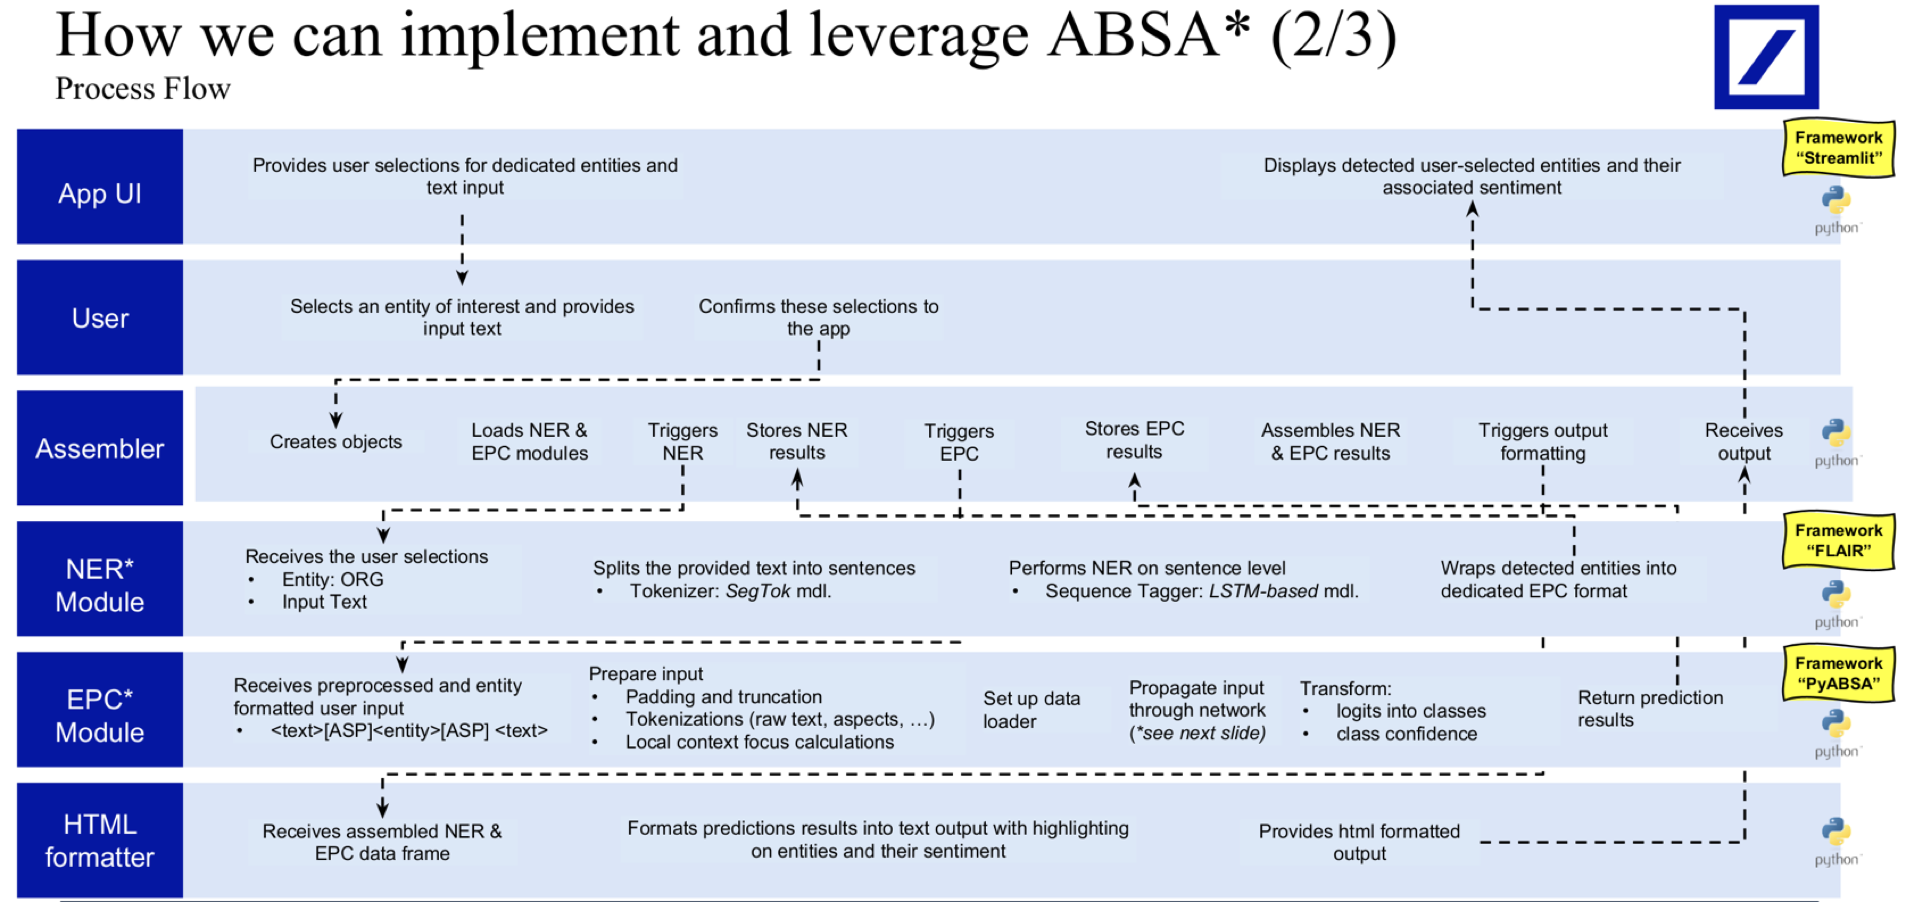
    
* an exemplary user input could look like this:
> "The 150-year-old Deutsche Bank AG (DB) and their CEO Christian Sewing announced on Sunday a much-awaited radical transformation that the embattled company hopes will make it leaner and meaner and able to survive in the long term."

* the output of the ABSA model pipeline can be exemplified as indicated below:
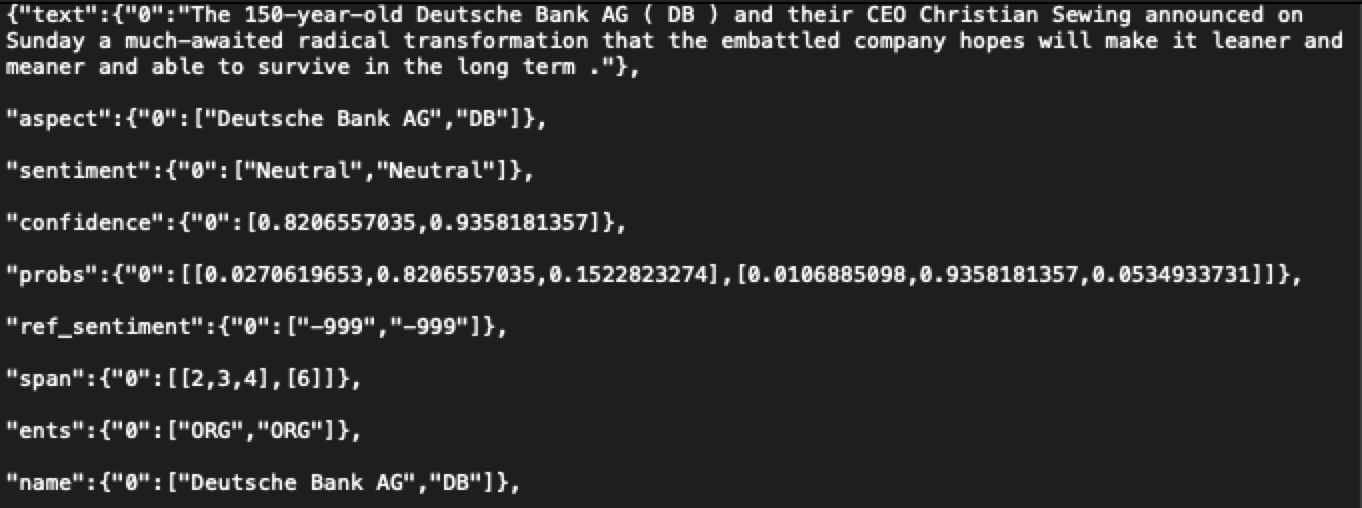



* for the general process of comparing the ABSA model with validation data this means that:
> 1. we would provide some refinitiv text to the model
> 2. let the model predict the entity and respective sentiment towards this entity
> 3. check whether the Refinitv data and annotations match with the model predictions
> 4. compute a quality metric (i.e. Acc or F1) to quantitivly define the models performance

* in the following sections I will investigate the Refinitiv data and in how far this data is suitabel for ABSA model validation. 

<br/>
<br/><br/><br/>

# Investigation of Refinitiv data set
below you will find a dedicated exploration of a Refinitiv data sample. This serves to check if and how far we can use the data for model validation on the developed ABSA pipeline.

In [11]:
import os
import pandas as pd

In [7]:
df = pd.read_json('/Users/jan-frederic.roser/PycharmProjects/ABSA_DEV/ABSA/json_mod/datanAQN04ZAXY_modified.json', orient="records")

#### the Refinitv data comprises essentially 4 keys
* headline and body can be merged to one consecutive text as both comprise relevant aspects for ABSA.
* analytics is the section that essentially should comprise the annotated entities with respective sentiment on the provided input text
* metadata is not of interest for this investigation (however it will be quickly investigated in the end of this section)

In [10]:
df.keys()

Index(['headline', 'body', 'analytics', 'metadata'], dtype='object')

#### an exemplary sample for investigation on the above stated keys 

* when merging body and headline for the ABSA predictions text formatting (escape character, line breaks, powers, ...) need to be considered and investigated w.r.t. prediction influences.

In [12]:
df.iloc[0].headline

"Diluent shortage curbs Venezuela's September oil exports, data shows"

In [17]:
print(df.iloc[0].body)

    By Marianna Parraga and Mircely Guanipa
    HOUSTON, Oct 4 (Reuters) - Venezuela's oil exports last
month sank to the lowest in almost a year, disrupted by a lack
of diluents that led to sizable production losses at its main
producing region, the Orinoco Belt, documents and tanker
tracking data showed.
    Years of mismanagement and U.S. sanctions have curtailed
state-run Petroleos de Venezuela's ability to produce and import
enough light crude and refined products to mix its extra heavy
oil into exportable grades. 
    The shortage since August has kept the Orinoco under an
emergency declared by PDVSA because of production setbacks at
oilfields and blending stations, which also have created delays
for shipping, according to company documents.    
    PDVSA and its joint ventures exported 414,000 barrels per
day (bpd) in a total of 19 cargoes last month, a 34% decline
from the previous month https://graphics.reuters.com/VENEZUELA-OIL/EXPORTS/nmovaxqarpa
 and the lowest since Octobe

### Observation w.r.t. Refintiv annotations on the above stated text
* as we can see below essentially two company (CMPNY) entities are provided by Refinitiv for the above stated text:
> 'Petroleos de Venezuela SA'\
>'Petrolera del Conosur SA'

* both of those entities are not explicitly mentioned in the text
> 'Petroleos de Venezuela SA' --> is mentioned as Petroleos de Venezuela\
> 'Petrolera del Conosur SA' --> is not mentioned at all (only Petrolera is mentioned in the text)

> Would be interessting to know whether Refinitiv uses a dedicated Ontology for detected entites to map them to the above stated companies.\
> It is also unclear whether Refinitiv uses some kind of sentiment aggregation logic to infer the sentiment for one entity if it is mentioned multiple times.
> A general NER or ATE module would not be able to extract the provided CMPNY entites and hence model evaluation and fine-tuning is problematic.
>> I.e. the NER model that I implemented in the ABSA inference pipeline recognizes the following 'ORG' entites on the aboove presented text:
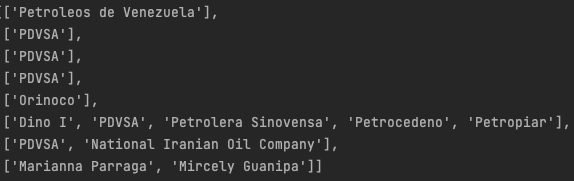
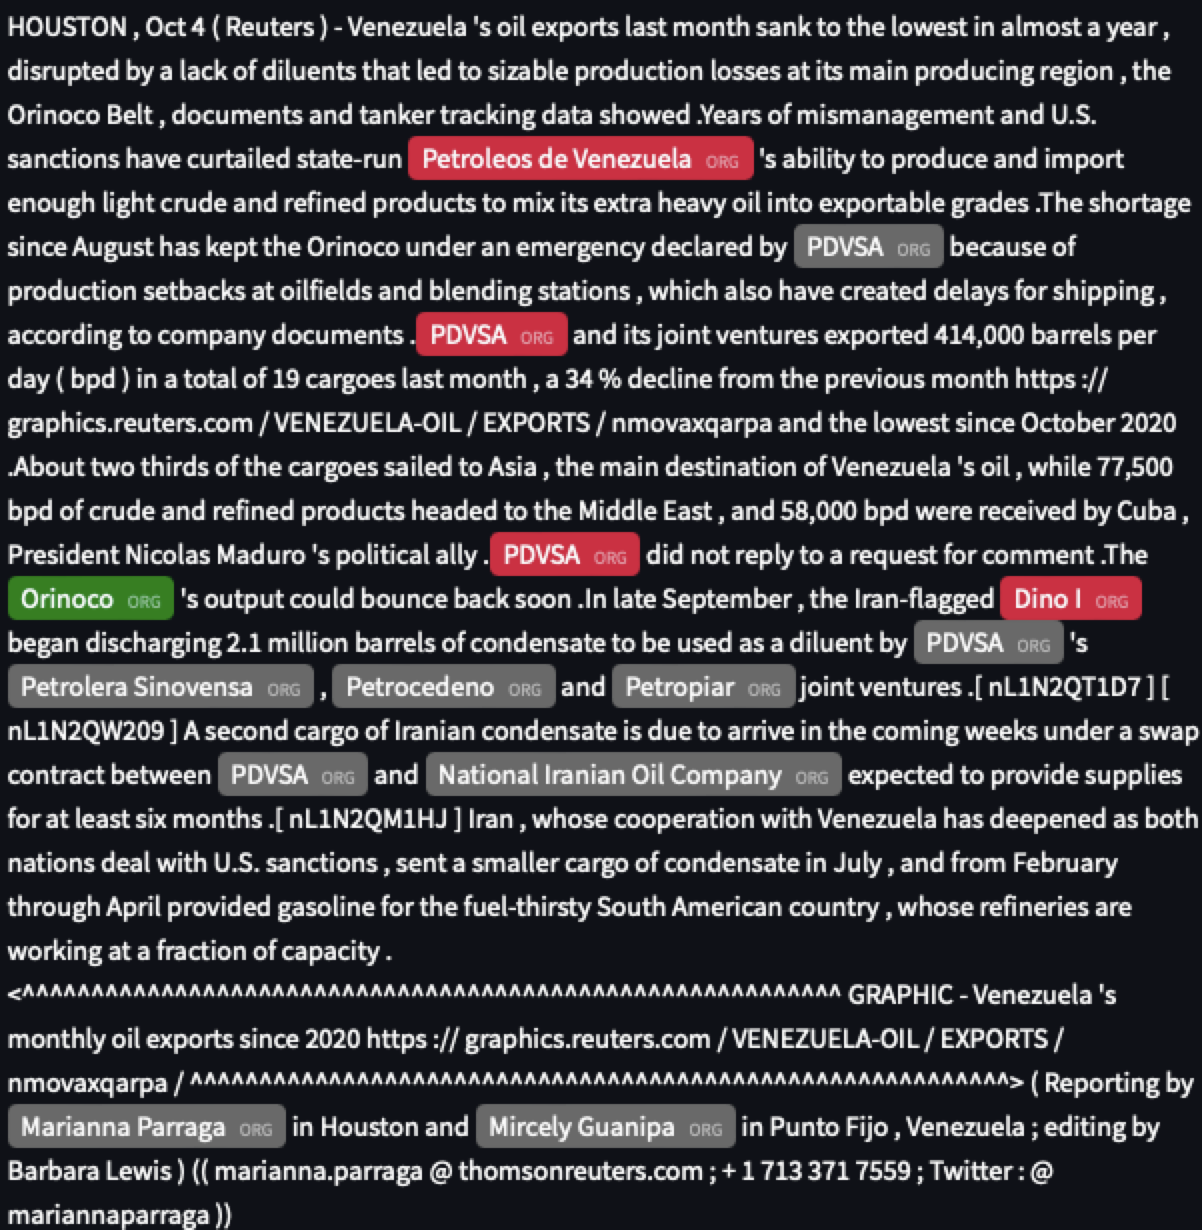
* both of the provided CMPNY entites are annotated w.r.t. their first appearance and the respective sentiment
> What if the entity appears multiple times in the text with different sentiment? This would not be covered by the Refinitiv annotations.\
> Our approach for the ABSA task is to
>> 1. identify each company within the text and
>> 2. auto. annotate the sentiment for each identitfied company\

* based on the refinitiv data we will not be able to validate this approach)

#### exemplification of the provided annotations by Refinitiv

* sentiment scores define: the probability that the sentiment of the news item was actually neg/pos/neu.
* sentiment is annotated on the corpus level according to the guidelines 
> no matter how often a entity (assetName) is mentioned an overall sentiment score for that specific entity is calculated.

In [14]:
df.iloc[0].analytics

{'0': {'permId': '4295916203',
  'ric': [],
  'ISIN': [],
  'CUSIP': [],
  'assetClass': 'CMPNY',
  'assetId': '4295916203',
  'assetName': 'Petroleos de Venezuela SA',
  'firstMentionSentence': 1,
  'relevance': 1.0,
  'sentimentClass': -1,
  'sentimentNegative': 0.599556,
  'sentimentNeutral': 0.13638,
  'sentimentPositive': 0.264063,
  'sentimentWordCount': 536},
 '1': {'permId': '4298047502',
  'ric': [],
  'ISIN': [],
  'CUSIP': [],
  'assetClass': 'CMPNY',
  'assetId': '4298047502',
  'assetName': 'Petrolera del Conosur SA',
  'firstMentionSentence': 9,
  'relevance': 0.13484000000000002,
  'sentimentClass': 0,
  'sentimentNegative': 0.26048299999999996,
  'sentimentNeutral': 0.38872,
  'sentimentPositive': 0.35079699999999997,
  'sentimentWordCount': 43},
 '2': {'permId': '',
  'ric': [],
  'ISIN': [],
  'CUSIP': [],
  'assetClass': 'COM',
  'assetId': 'CRU',
  'assetName': 'Crude oil',
  'firstMentionSentence': 1,
  'relevance': 1.0,
  'sentimentClass': -1,
  'sentimentNegative

### Observation on metadata key

* Refinitiv lists all found entities (i.e. ORG, GPE, DATA, ...) within a metadata filed (metadata['ner']) - but only the dedicated entity and the number of times it has been detected (no sentiment or text position reference).



In [18]:
df.iloc[0].metadata.keys()

dict_keys(['id', 'idType', 'sector', 'geography', 'assetClass', 'keywords', 'ner'])

In [20]:
df.iloc[0].metadata['assetClass']

['Commodities Markets']

In [21]:
df.iloc[0].metadata['id']

'nL1N2QX2N9'

In [22]:
df.iloc[0].metadata['idType']

'altId'

In [23]:
df.iloc[0].metadata['sector']

['Integrated Oil & Gas (TRBC level 5)',
 'Energy (TRBC level 1)',
 'Oil & Gas (TRBC level 3)',
 'Oil & Gas Refining and Marketing (NEC) (TRBC level 5)',
 'Oil & Gas Refining and Marketing (TRBC level 4)',
 'Energy - Fossil Fuels (TRBC level 2)',
 'Integrated Oil & Gas (TRBC level 4)']

In [24]:
df.iloc[0].metadata['geography']

['Emerging Market Countries',
 'Venezuela',
 'Argentina',
 'Americas',
 'South America',
 'South America / Central America']

In [26]:
df.iloc[0].metadata['keywords']

[{'rank': 1,
  'keyword': 'venezuela oil exports',
  'score': 0.202812759,
  'count': 0},
 {'rank': 2, 'keyword': 'exportable', 'score': 0.1916267261, 'count': 1},
 {'rank': 3, 'keyword': 'cargoes', 'score': 0.1653027125, 'count': 2},
 {'rank': 4, 'keyword': 'refined products', 'score': 0.1494709034, 'count': 2},
 {'rank': 5, 'keyword': 'graphic', 'score': 0.14055212920000001, 'count': 3},
 {'rank': 6, 'keyword': 'reuters', 'score': 0.1340328334, 'count': 4},
 {'rank': 7, 'keyword': 'months', 'score': 0.1333783241, 'count': 1},
 {'rank': 8,
  'keyword': 'joint ventures exported',
  'score': 0.12387596340000001,
  'count': 1},
 {'rank': 9, 'keyword': 'iranian', 'score': 0.1232402866, 'count': 2},
 {'rank': 10,
  'keyword': 'sizable production losses',
  'score': 0.11780728530000001,
  'count': 1},
 {'rank': 11, 'keyword': 'company', 'score': 0.1176363898, 'count': 2},
 {'rank': 12, 'keyword': 'second cargo', 'score': 0.1125300156, 'count': 1},
 {'rank': 13,
  'keyword': 'provide supplie

In [27]:
df.iloc[0].metadata['ner']

[{'name': 'Marianna Parraga', 'label': 'PERSON', 'count': 2},
 {'name': 'Mircely Guanipa', 'label': 'PERSON', 'count': 2},
 {'name': 'HOUSTON', 'label': 'GPE', 'count': 1},
 {'name': 'Oct 4', 'label': 'DATE', 'count': 1},
 {'name': 'Reuters', 'label': 'ORG', 'count': 1},
 {'name': 'Venezuela', 'label': 'GPE', 'count': 5},
 {'name': 'last\n', 'label': 'DATE', 'count': 1},
 {'name': 'almost a year', 'label': 'DATE', 'count': 1},
 {'name': 'the Orinoco Belt', 'label': 'LOC', 'count': 1},
 {'name': 'U.S.', 'label': 'GPE', 'count': 2},
 {'name': 'Petroleos de Venezuela', 'label': 'ORG', 'count': 1},
 {'name': 'August', 'label': 'DATE', 'count': 1},
 {'name': 'Orinoco', 'label': 'ORG', 'count': 2},
 {'name': 'PDVSA', 'label': 'ORG', 'count': 5},
 {'name': 'oilfields', 'label': 'FAC', 'count': 1},
 {'name': '414,000 barrels', 'label': 'QUANTITY', 'count': 1},
 {'name': '19', 'label': 'CARDINAL', 'count': 1},
 {'name': 'last month', 'label': 'DATE', 'count': 1},
 {'name': '34%', 'label': 'PERC

# a few more samples which indicated the challenge with the Refnitiv data


### the below stated sample is a good indication of the problematic annotation of Refinitiv

* in the text the company "Mallinckrodt" is mentioned for 3 times with different names (Mallinckrodt and Mallinckrodt PLD) 
> In the analytics annotations this company is annotated as: Mallinckrodt PLD\
> It is annotated only one time with the reference that it appear the first time in sentence nr. 3\
> Even though it appears three times there is one sentiment for this CMPNY annotation (which is negative)\
> It is not clear whether this is a mean sentiment for the three mentionings or whether this sentiment applies only on the first appreance (that is acutally annotated).

* It is also not clear why some entities which are clear ORG entities are not annotated by Refinitiv (i.e. U.S. Centers for Disease Control and Prevention) 
> Another point for consideration would be whether either their model does not recognize those entities (if they use a model) or whether they filter for dedicated companies vs. institutions in the first place?!

In [31]:
df.iloc[1].headline

'UPDATE 1-U.S. Supreme Court rejects challenge to New York tax on opioid companies'

In [32]:
print(df.iloc[1].body)

 (Adds background to case, paragraphs 3-12)
    By Lawrence Hurley and Nate Raymond
    WASHINGTON, Oct 4 (Reuters) - The U.S. Supreme Court on
Monday cleared the way for New York to collect a $200 million
surcharge imposed on opioid manufacturers and distributors to
defray the state's costs arising from the deadly epidemic
involving the powerful painkilling drugs.
    The justices declined to hear an appeal by two trade groups
representing drug distributors and generic drug makers and a
unit of British-based pharmaceutical company Mallinckrodt Plc
<MCDG.MU> of a lower court's decision upholding the surcharge.
    The law's challengers included the Association for
Accessible Medicines, whose members include drugmakers Teva
Pharmaceutical Industries Plc<TEVA.TA> and Mallinckrodt, and the
Healthcare Distribution Alliance, which represents wholesale
distributors.
    The alliance's members include the three largest drug
distributors, McKesson Corp<MCK.N>, AmerisourceBergen
Corp<ABC.N> and

In [33]:
df.iloc[1].analytics

{'0': {'permId': '4295875158',
  'ric': ['TEVA.K', 'TEVA.TA'],
  'ISIN': ['IL0006290147', 'US8816242098'],
  'CUSIP': ['', '881624209'],
  'assetClass': 'CMPNY',
  'assetId': '4295875158',
  'assetName': 'Teva Pharmaceutical Industries Ltd',
  'firstMentionSentence': 4,
  'relevance': 0.204124,
  'sentimentClass': -1,
  'sentimentNegative': 0.744096,
  'sentimentNeutral': 0.182898,
  'sentimentPositive': 0.07300559999999999,
  'sentimentWordCount': 68},
 '1': {'permId': '4295903374',
  'ric': ['ABC.N'],
  'ISIN': ['US03073E1055'],
  'CUSIP': ['3.07E+108'],
  'assetClass': 'CMPNY',
  'assetId': '4295903374',
  'assetName': 'Amerisourcebergen Corp',
  'firstMentionSentence': 5,
  'relevance': 0.204124,
  'sentimentClass': -1,
  'sentimentNegative': 0.696542,
  'sentimentNeutral': 0.111944,
  'sentimentPositive': 0.191514,
  'sentimentWordCount': 57},
 '2': {'permId': '4295903651',
  'ric': ['CAH.N'],
  'ISIN': ['US14149Y1082'],
  'CUSIP': ['14149Y108'],
  'assetClass': 'CMPNY',
  'assetI

#### This is what our model would find w.r.t. ORG entities
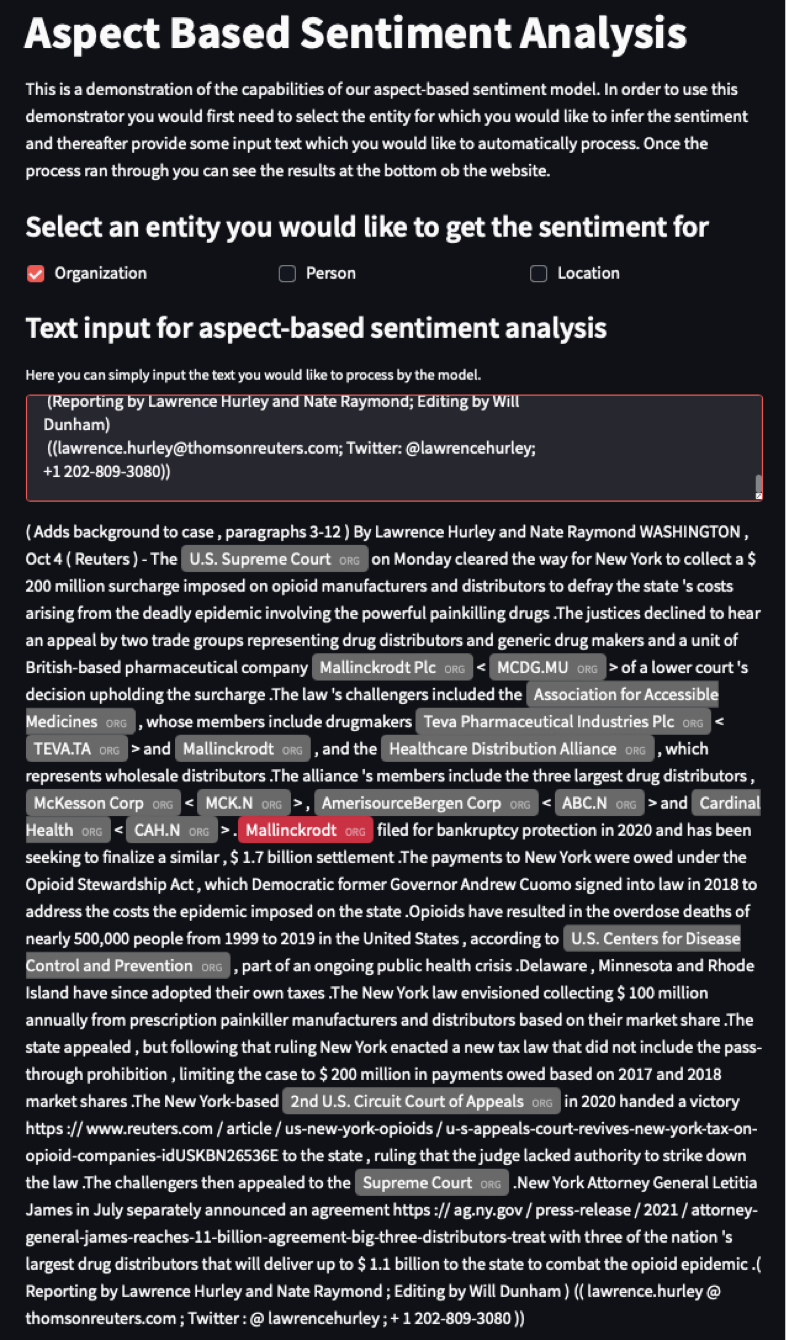

### the below stated sample is a good indication why the headline & the body are of relevance

* in this sample both, the in the text stated entitiy and the by Refinitiv annotated entity match
* However Refinitiv does not mention "SEBI" as a CMPNY entity while it does detect "SEBI" as ORG in their NER lables --> compared to "YASH TRADING & FINANCE LTD" which is not listed under the metadata NER labels.

In [42]:
df.iloc[2].headline

"General - YASH TRADING & FINANCE LTD. - Reporting Of Initial Disclosure To Be Made By Entities Considered As ''Large Corporate'' Under The SEBI Circular SEBI/HO/DDHS/CIR/P/2018/144 Dated 26-11-2018"

In [43]:
print(df.iloc[2].body)


Pursuant to SEBI circular SEBI/HO/DDHS/CIR/P/2018/144 dated 26-Nov-2018 read
with BSE circular no. LIST/COMP/05/2019-20 dated 11-04-2019, we hereby confirm
that our Company ''Yash Trading and Finance Limited'' (Scrip Code: 512345) do
not fall under the criteria applicable to be classified as Large Corporate
mentioned in clause 2.2 of the aforementioned SEBI circular.
Kindly take the same on records.

http://newsfile.refinitiv.com/getnewsfile/v1/story?guid=urn:newsml:reuters.com:20211004:nBSE8Dsf14




In [44]:
df.iloc[2].analytics

{'0': {'permId': '4297728838',
  'ric': ['YAST.BO', 'YAST.INx'],
  'ISIN': [],
  'CUSIP': [],
  'assetClass': 'CMPNY',
  'assetId': '4297728838',
  'assetName': 'Yash Trading and Finance Ltd',
  'firstMentionSentence': 1,
  'relevance': 1.0,
  'sentimentClass': 1,
  'sentimentNegative': 0.11300299999999999,
  'sentimentNeutral': 0.38407,
  'sentimentPositive': 0.502927,
  'sentimentWordCount': 103}}

#### This is what our model would find w.r.t. ORG entities
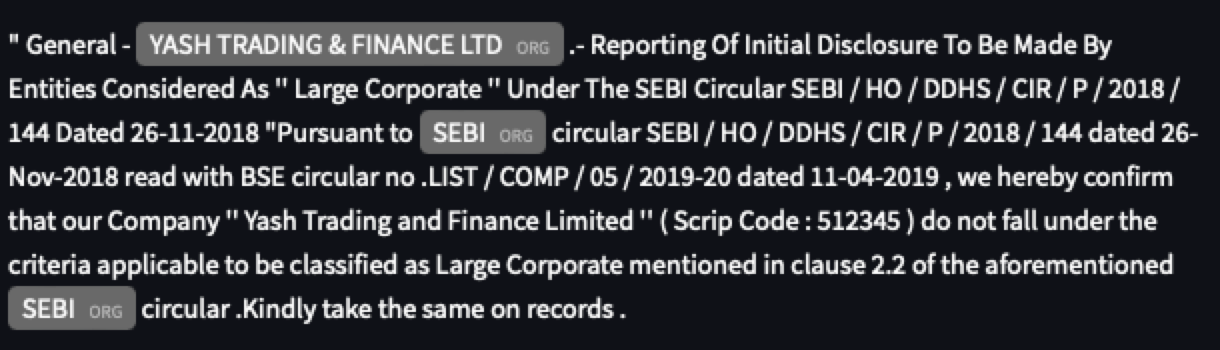

In [45]:
df.iloc[2].metadata['ner']

[{'name': 'SEBI', 'label': 'ORG', 'count': 2},
 {'name': 'SEBI/HO/DDHS/CIR/', 'label': 'LAW', 'count': 1},
 {'name': '26-Nov-2018 read\n', 'label': 'DATE', 'count': 1},
 {'name': '11-04-2019', 'label': 'DATE', 'count': 1},
 {'name': '512345', 'label': 'CARDINAL', 'count': 1},
 {'name': '2.2', 'label': 'CARDINAL', 'count': 1}]

# another problematic sample
* Below one can see that the headline and body comprise multiple entities 
* However, Refinitiv only annotates one CMPNY entity ('Fondul Proprietatea SA') as being relevant.
* Our model predicts multiple ORG entities and the respective sentiment
* Another Point is also the text format - we might need to think about ways to handle different formats as the format itself will influence also the model predictions

#### This is the original content and annotation by Ref.

In [48]:
df.iloc[3].headline

"REG - Fondul Proprietatea  - Notification buybacks 27 September - 1 October '21"

In [53]:
print(df.iloc[3].body)

For best results when printing this announcement, please click on link below:
http://newsfile.refinitiv.com/getnewsfile/v1/story?guid=urn:newsml:reuters.com:20211004:nRSD9496Na&default-theme=true

RNS Number : 9496N  Fondul Proprietatea S.A.  04 October 2021

 To:    FINANCIAL SUPERVISORY AUTHORITY
        BUCHAREST STOCK EXCHANGE
        LONDON STOCK EXCHANGE

 Re:    Notification regarding the buy-back transactions

 From:  FONDUL PROPRIETATEA S.A.

 

Considering article 2 of Commission Delegated Regulation (EU) 2016/1052
supplementing Regulation (EU) No 596/2014 of the European Parliament and of
the Council with regard to regulatory technical standards for the conditions
applicable to buy-back programmes and stabilisation measures, Article 5(3) of
Regulation (EU) No 596/2014 on market abuse (market abuse regulation) and
Article 26 (3) of Regulation (EU) No 600/2014 on markets in financial
instruments, FONDUL PROPRIETATEA S.A. ("FP" / the "Fund"), represented by
Franklin Templeton I

In [51]:
df.iloc[3].analytics

{'0': {'permId': '5000044404',
  'ric': ['FP.BX'],
  'ISIN': ['ROFPTAACNOR5'],
  'CUSIP': [''],
  'assetClass': 'CMPNY',
  'assetId': '5000044404',
  'assetName': 'Fondul Proprietatea SA',
  'firstMentionSentence': 1,
  'relevance': 1.0,
  'sentimentClass': 1,
  'sentimentNegative': 0.159234,
  'sentimentNeutral': 0.39339,
  'sentimentPositive': 0.447376,
  'sentimentWordCount': 425}}

#### This is what our model would predict
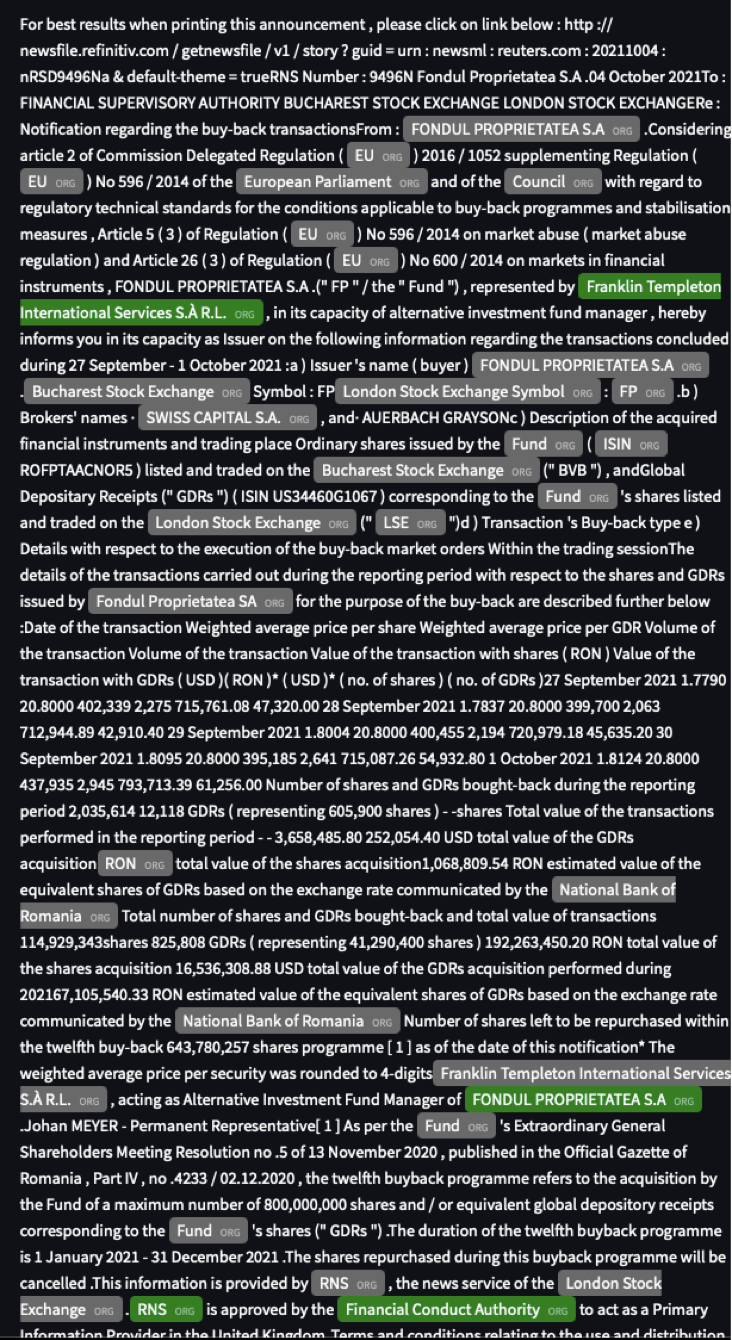

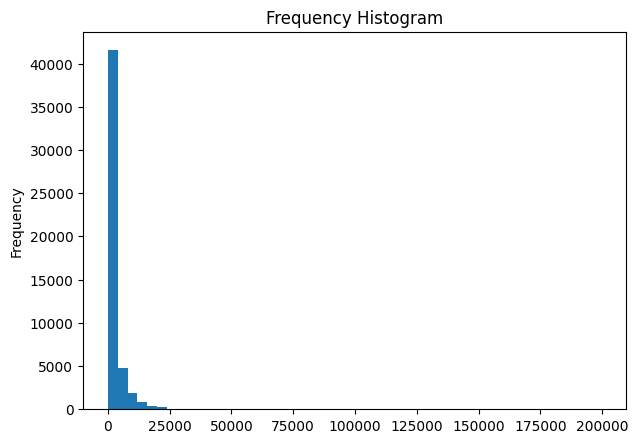

In [75]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# get token length of the body+headline 
L = []
for i in range(df.shape[0]):
    L.append(len(df.iloc[i].headline + '. ' + df.iloc[i].body))
    

# Plot Histogram on x
plt.hist(L, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [84]:
L.index(199566)

32711

### example for the SHORTEST sequence length (sample) provided by Refinitive
* our ABSA model could not make any prediction on this sample below. How does Refinitiv annotated that data? 
* clearly this is a case which we could not use for validation

In [80]:
print(df.iloc[28310].headline + '. ' + df.iloc[28310].body)

. 


In [81]:
df.iloc[28310].analytics

{'0': {'permId': '4298546613',
  'ric': ['MYS.AX'],
  'ISIN': ['AU000000MYS0'],
  'CUSIP': [''],
  'assetClass': 'CMPNY',
  'assetId': '4298546613',
  'assetName': 'MyState Ltd',
  'firstMentionSentence': 0,
  'relevance': 1.0,
  'sentimentClass': 0,
  'sentimentNegative': 0.0141482,
  'sentimentNeutral': 0.8100769999999999,
  'sentimentPositive': 0.175775,
  'sentimentWordCount': 1}}

In [83]:
df.iloc[28310].metadata

{'id': 'nFWN2RF1K2',
 'idType': 'altId',
 'sector': ['Banks (TRBC level 4)',
  'Banks (NEC) (TRBC level 5)',
  'Banking Services (TRBC level 3)',
  'Financials (TRBC level 1)',
  'Banking & Investment Services (TRBC level 2)'],
 'geography': ['Australia', 'Asia / Pacific', 'Australia / New Zealand'],
 'assetClass': [],
 'keywords': [],
 'ner': []}

### example for the LONGEST sequence length (sample) provided by Refinitive
* our ABSA model does detect way more than 1 CMPNY entiy
* how should we proceed with evaluation?! f.m.p.o.v. we should have new annotations on this.

In [86]:
print(df.iloc[32711].headline + '. ' + df.iloc[32711].body)

Pacific Premier Bancorp, Inc. Announces Third Quarter 2021 Financial Results and a Quarterly Cash Dividend of $0.33 Per Share. For best results when printing this announcement, please click on link below:
http://newsfile.refinitiv.com/getnewsfile/v1/story?guid=urn:newsml:reuters.com:20211021:nBw1cJCTpa&default-theme=true


Pacific Premier Bancorp, Inc. Announces Third Quarter 2021 Financial Results
and a Quarterly Cash Dividend of $0.33 Per Share

Third Quarter 2021 Summary


 * Net income of $90.1 million, or $0.95 per diluted share

 * Total revenue increased to $199.2 million, compared with $187.7 million in the
prior quarter

 * Return on average assets of 1.73%, return on average equity of 12.67%, and
return on average tangible common equity of 19.89%((1))

 * Pre-provision net revenue ("PPNR") on average assets of 1.98%, annualized,
and efficiency ratio of 47.5%((1))

 * Loan and deposit growth of 11.5% and 10.7%, annualized, respectively

 * Net interest margin of 3.51%, compare

In [89]:
df.iloc[32711].analytics

{'0': {'permId': '4295906999',
  'ric': ['PPBI.O', 'PPBI.OQ'],
  'ISIN': ['US69478X1054'],
  'CUSIP': ['69478X105'],
  'assetClass': 'CMPNY',
  'assetId': '4295906999',
  'assetName': 'Pacific Premier Bancorp Inc',
  'firstMentionSentence': 1,
  'relevance': 1.0,
  'sentimentClass': 1,
  'sentimentNegative': 0.330476,
  'sentimentNeutral': 0.32017,
  'sentimentPositive': 0.349354,
  'sentimentWordCount': 1934}}

In [93]:
for org in df.iloc[32711].metadata['ner']:
    if org['label'] == 'ORG':
        print(org['name'])

Pacific Premier Bancorp, Inc.
PPBI
Pacific
Premier
Pacific Premier Bank
Bank
non-U.S.


# Key takeaway
* the ABSA model outputs can not directly be evaluated on the Refinitiv data annotations
> not clear whether the Refinitiv Document Level Scoring is the right data --> there should be also a Asset Level Scoring report provided by Refinitiv
* the annotations of the Refinitiv data are on entity-sentiment-document level 
* our model predicts sentiment on a sentence level and aspect basis (could be multiple predicts of sentiment per sentence)
* based on the current Refinitiv annotations a model evaluation for the ABSA model is only possible if certain adaptions are made
 > 1. provide Refinitv headline + body to the model\
 > 2. predict entities\
 > 3. group predicted entites according to some similarity measure\
 > 4. check whether a entity group matches one of the Refinitv assetName annotations\
 > 5. if a match is found, infer the sentiment for this match via a sentiment aggregtion method\
 > 6. compare the infered sentiment to the sentiment annotations to get some sense of overlap between Refinitiv and ABSA model
* based on the current Refinitiv annotations a model training for the ABSA model is not possible 